# Computer Vision Workshop

Dieses Tutorial zeigt, wie man mittels eines Neuronalen Netzwerks / Deep Learning einen Bild-Klassifizierer baut, der Katzenbilder von Hundebildern unterscheidet.

Diese Aufgabenstellung kommt aus dem ["Cats vs. Dogs"](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition) Wettbewerb der Website Kaggle.

Basis bildet ein Convolutional Neuronal Network (CNN) namens "VGG16", welches auf Basis der Daten des [Imagenet Datasets](http://image-net.org/synset?wnid=n02084071) vortrainiert wurde. Das Modell wird durch Umkonfiguration und Re-Training so angepasst, dass es die gestellte Aufgabe lösen kann.

Die Grundlagen zu diesem Workshop kommen aus dem Deep Learning MOOC [fast.ai](http://fast.ai).

In [51]:
%matplotlib inline

## Data preparation

Die Daten des Kaggle Wettbewerbs wurden schon vorbereitet und in der "richtigen" Struktur abgelegt.
Das Verzeichnis `data` enthält die Trainings- und Validierungsdaten aus dem Dataset. Dabei sind die Bilder zu jeder zu erkennenden "Klasse" (Cats & Dogs in unserem Fall) in einem eigenen Unterverzeichnis abgelegt:

In [52]:
# ! führt einen Shell-Befehl aus...
!tree -d data 

data
├── results
├── test
│   └── unknown
├── train
│   ├── cats
│   └── dogs
└── valid
    ├── cats
    └── dogs

9 directories


Mal schauen, wieviele Dateien in den Trainings- und Validerungsdaten drin sind:

In [53]:
!echo -n "Training cats: " && ls data/train/cats | wc -w
!echo -n "Training dogs: " && ls data/train/dogs | wc -w
!echo -n "Validation cats: " && ls data/valid/cats | wc -w
!echo -n "Validation dogs: " && ls data/valid/dogs | wc -w

Training cats: 11567
Training dogs: 11433
Validation cats: 933
Validation dogs: 1067


Das Verzeichnis `test` enthält die Bilder, die nicht klassifizert sind (deshalb das Unterverzeichnis `unknown`). Diese wollen wir nach dem Training bestimmen. Mal sehen, wieviele das sind:

In [54]:
!echo -n "Test: " && ls data/test/unknown | wc -w

Test: 12500


Damit wir am Code herumprobieren können, ohne gleich lange Laufzeiten aufgrund der vielen Dateien zu erhalten, gibt es noch ein `sample` Dataset, welches gleich aufgebaut ist, aber nur nur einen kleinen Teil der Daten enthält:

In [55]:
!tree -d sample

sample
├── results
│   ├── filenames.dat
│   │   ├── data
│   │   └── meta
│   └── predictions.dat
│       ├── data
│       └── meta
├── test
│   └── unknown
├── train
│   ├── cats
│   └── dogs
└── valid
    ├── cats
    └── dogs

15 directories


In [56]:
!echo -n "Training cats: " && ls sample/train/cats | wc -w
!echo -n "Training dogs: " && ls sample/train/dogs | wc -w
!echo -n "Validation cats: " && ls sample/valid/cats | wc -w
!echo -n "Validation dogs: " && ls sample/valid/dogs | wc -w
!echo -n "Test: " && ls sample/test/unknown | wc -w

Training cats: 100
Training dogs: 100
Validation cats: 25
Validation dogs: 25
Test: 25


## Training

In [57]:
from glob import glob
import numpy as np
import shutil
import os.path
# from __future__ import division,print_function

#import os, json
import numpy as np
#import time
np.set_printoptions(precision=4, linewidth=100)
# from matplotlib import pyplot as plt
#import utils; reload(utils)
#from utils import plots

Hier setzen wir den Pfad für die Daten, mit denen wir arbeiten wollen (also `data` oder `sample`):

In [60]:
# path = "data/"
path = "sample/"
path = os.path.join(os.path.curdir,path)
print path

./sample/


Wir laden die Python Klasse, welche das Modell (ein CNN) in ein nettes, mehr oder weniger objektorientiertes API verpackt. Der Sourcecode dazu steht in der Datei `vgg16.py`.

In [61]:
# As large as you can, but no larger than 64 is recommended. 
# If you have an older or cheaper GPU, you'll run out of memory, so will have to decrease this.
batch_size=64

# Wie viele Durchläufe durch die Trainingsdaten sollen gemacht werden:
epochs = 1

# Import VGG16 class, and instantiate
import vgg16; reload(vgg16)
from vgg16 import Vgg16
vgg = Vgg16()

Wir laden die Trainings- und Validierungsdaten als "Batches". `vgg.get_batches()` setzt voraus, dass die Daten in Unterverzeichnissen je Kategorie abgelegt sind. Genau das ist bei uns der Fall, wie wir oben gesehen haben.

Dann wird das VGG16 Modell an unsere Aufgabe ("cat or dog" Klassifizierung) angepasst: `vgg.finetune()`.

In [62]:
batches = vgg.get_batches(os.path.join(path,'train'), batch_size=batch_size)
val_batches = vgg.get_batches(os.path.join(path,'valid'), batch_size=batch_size*2)
vgg.finetune(batches)

Found 200 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [49]:
??vgg.finetune

In [50]:
??vgg.ft

Jetzt trainieren wir das Modell mit den Daten über `vgg.fit()`. Dabei wird in Wahrheit nur noch der letze (modifizierte) Layer des angepassten VGG16 Modells trainiert.

Die angepassten Gewichte des Modells schreiben wir in eine Datei, so dass wir sie später wieder laden können und so nicht jedesmal das Training wiederholen müssen.

In [63]:
# Learning rate:
vgg.model.optimizer.lr = 0.01

results_path = os.path.join(path,'results')

for epoch in range(1,epochs+1):
    print 'fit epoch {}'.format(epoch)
    vgg.fit(batches, val_batches, nb_epoch=1)
    weights_filename = os.path.join(results_path,'vgg_weights-{}.h5'.format(epoch))
    print 'saving weights to {}'.format(weights_filename)
    vgg.model.save_weights(weights_filename)


fit epoch 1
Epoch 1/1
200/200 [==============================] - 8s - loss: 1.2823 - acc: 0.6900 - val_loss: 0.2186 - val_acc: 0.9400
saving weights to ./sample/results/vgg_weights-1.h5


## Vorhersage / Klassifizierung (Prediction)

Jetzt klassifizieren wir die Bilder, die im Unterverzeichnis 'test' abgelegt sind.

Prediction Setup:

In [64]:
test_path = os.path.join(path,'test')
predictions_file = os.path.join(path,'results/predictions.dat')
filenames_file = os.path.join(path,'results/filenames.dat')

import utils
import time

Prediction durchführen und Ergebnisse speichern:

In [65]:
print('start predicting at {}'.format(time.asctime()))
batches, predictions = vgg.test(test_path,batch_size=batch_size*2)
print('stop predicting at {}'.format(time.asctime()))

utils.save_array(predictions_file, predictions)
utils.save_array(filenames_file, batches.filenames)

start predicting at Wed Nov 22 17:37:45 2017
Found 25 images belonging to 1 classes.
stop predicting at Wed Nov 22 17:37:49 2017


Mal ein paar Ergebnisse anschauen....

File:  unknown/11855.jpg Prediction:  [  2.2357e-25   1.0000e+00]


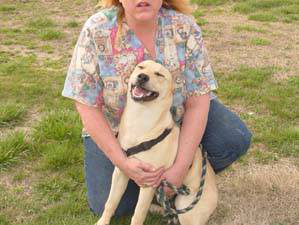

In [75]:
idx = -2

print "File: ", batches.filenames[idx], "Prediction: ", predictions[idx]
from PIL import Image
Image.open(os.path.join(test_path,batches.filenames[idx]))



In [68]:
??Image.open

## Visualize

Wir wollen uns auch anschauen, wie gut unser Modell eigentlich vorhersagt. Die Idee dazu ist, dass wir mit dem Modell eine Vorhersage über die bereits klassifizierten Trainingsdaten machen. So kennen wir die "ground truth" zu jedem Bild und können ermitteln, ob die Vorhersage korrekt war.

In [67]:
if not 'path' in locals():
    path = "sample/"
    # path = "data/"

#import numpy as np
import utils; reload(utils)
#import vgg16; reload(vgg16)
#from vgg16 import Vgg16

<module 'utils' from 'utils.pyc'>

Load the trained weights into the model

In [37]:
vgg = Vgg16()

weights_filename = '{path}results/vgg_weights-{epoch}.h5'.format(path=path,epoch=1)
vgg.model.load_weights(weights_filename)

Predict the validation data. This way we know the ground truth and are able to compare it with the predictions of our model.

In [38]:
valid_batches, predictions = vgg.test(path+'valid', batch_size=64)
expected_labels = valid_batches.classes
filenames = valid_batches.filenames

print predictions[:8]

our_predictions = predictions[:,0]
our_labels = np.round(1-our_predictions)
print our_labels[:8]

Found 50 images belonging to 2 classes.
[[  1.0000e+00   7.6811e-22]
 [  1.0000e+00   2.0716e-26]
 [  1.0000e+00   1.1773e-24]
 [  1.0000e+00   8.8600e-35]
 [  1.0000e+00   4.8278e-11]
 [  1.0000e+00   8.2289e-27]
 [  1.0000e+00   1.3577e-26]
 [  1.0000e+00   1.1256e-15]]
[ 0.  0.  0.  0.  0.  0.  0.  0.]


In [39]:
from keras.preprocessing import image
def plots_idx(idx, titles=None):
    utils.plots([image.load_img(path+'valid/'+filenames[i]) for i in idx], titles=titles)

### Zeige einige korrekte Klassifizierungen

Found 48 correct labels


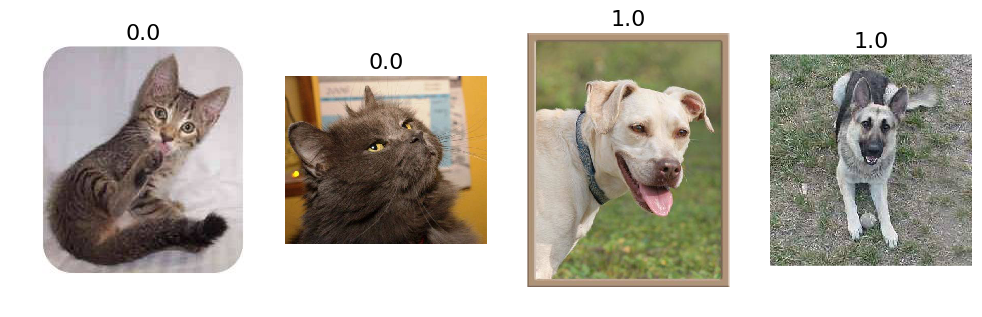

In [40]:
correct = np.where(our_labels==expected_labels)[0]
print "Found {} correct labels".format(len(correct))
idx = np.random.permutation(correct)[:4]
plots_idx(idx, our_labels[idx])

### Zeige einige falsche Klassifizierungen

Found 2 incorrect labels.


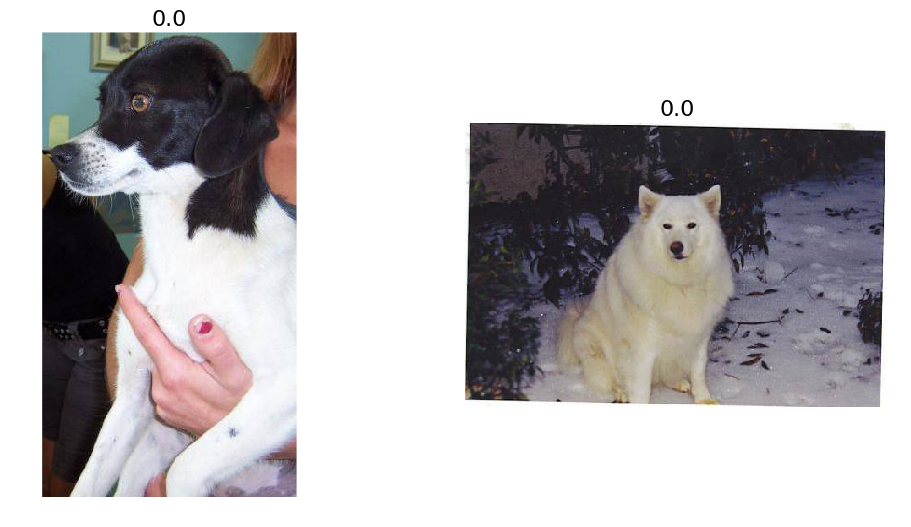

In [41]:
incorrect = np.where(our_labels!=expected_labels)[0]
print "Found {} incorrect labels.".format(len(incorrect))
idx = np.random.permutation(incorrect)[:4]
plots_idx(idx,our_labels[idx])

### Zeige einige richtige Klassifizierungen mit der größten Wahrscheintlichkeit

... also da, wo das Modell wirklich recht hatte.

Found 25 confident correct cats labels
Found 23 confident correct dogs labels


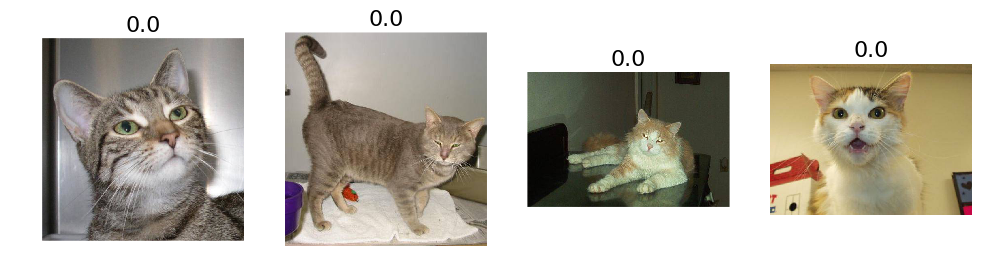

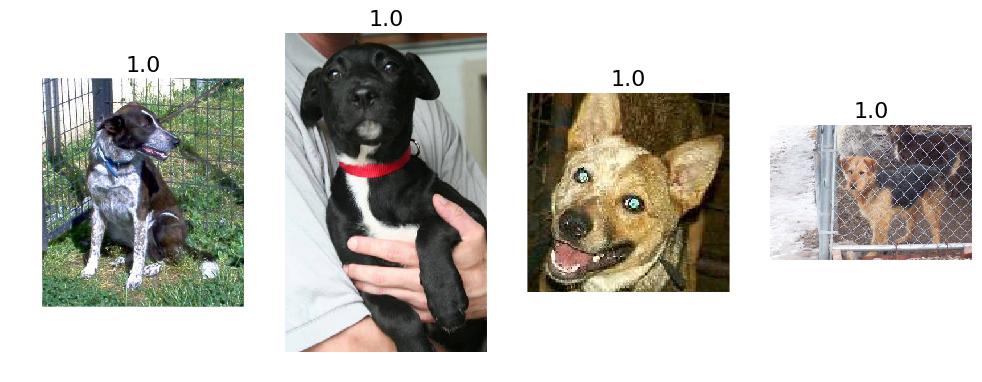

In [42]:
confident_cats = np.where((our_labels==expected_labels) & (our_labels==0))[0]
print "Found {} confident correct cats labels".format(len(confident_cats))
idx = np.random.permutation(confident_cats)[:4]
plots_idx(idx,our_labels[idx])

confident_dogs = np.where((our_labels==expected_labels) & (our_labels==1))[0]
print "Found {} confident correct dogs labels".format(len(confident_dogs))
idx = np.random.permutation(confident_dogs)[:4]
plots_idx(idx,our_labels[idx])

### Ziege einige falsche Klassifizierungen mit der größten Wahrscheinlichkeit

... also die, bei denen das Modell total daneben lag.

Found 2 confident incorrect cats labels
Found 0 confident incorrect dogs labels


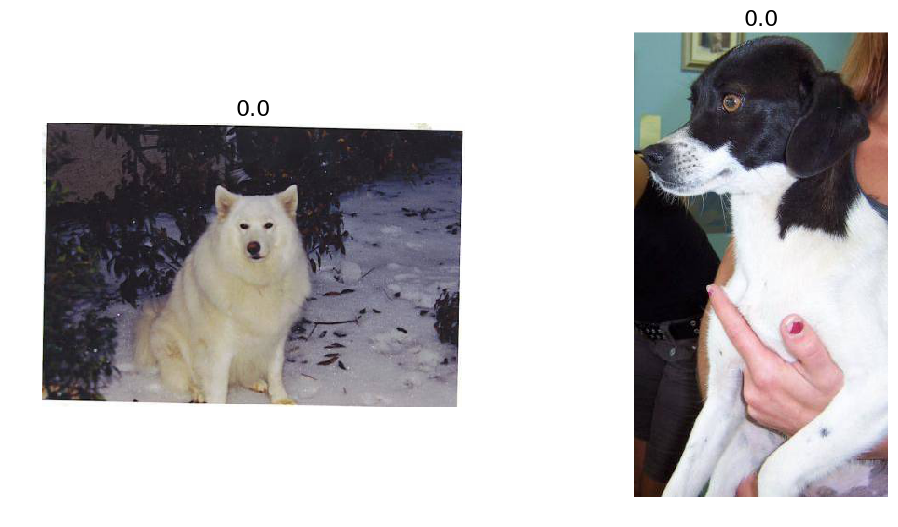

In [43]:
confident_cats = np.where((our_labels!=expected_labels) & (our_labels==0))[0]
print "Found {} confident incorrect cats labels".format(len(confident_cats))
if len(confident_cats)>0:
    idx = np.random.permutation(confident_cats)[:4]
    plots_idx(idx,our_labels[idx])

confident_dogs = np.where((our_labels!=expected_labels) & (our_labels==1))[0]
print "Found {} confident incorrect dogs labels".format(len(confident_dogs))
if len(confident_dogs)>0:
    idx = np.random.permutation(confident_dogs)[:4]
    plots_idx(idx,our_labels[idx])

### Ziege die unsichersten Klassifizierungen

... also die, bei denen sich das Modell nicht so sicher war.

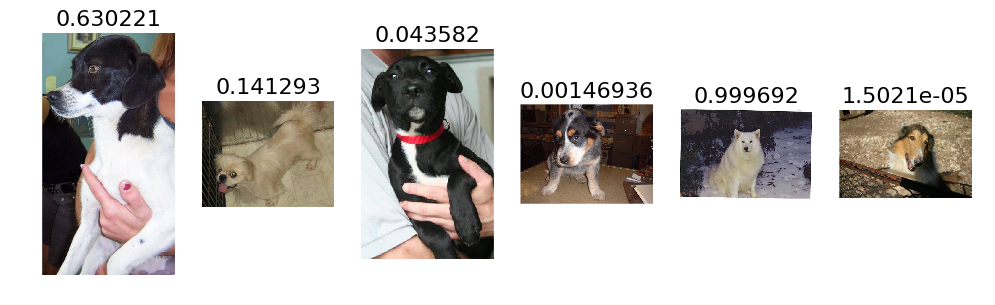

In [44]:
uncertain = np.argsort(np.abs(our_predictions-0.5))
plots_idx(uncertain[:6],our_predictions[uncertain])

### Confusion Matrix

[[25  0]
 [ 2 23]]


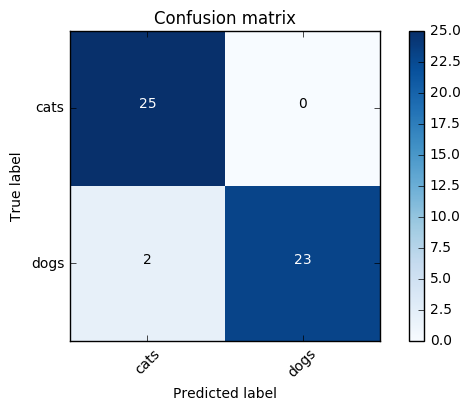

In [45]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(expected_labels,our_labels)
utils.plot_confusion_matrix(cm, valid_batches.class_indices)